# Stock Analysis

In this project I am trying to select a dataset that I have no knowledge about to challenge myself. After searching different data hobs I came across the **Huge Stock Market Dataset** in https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs . 
As I mentioned I had no prior knowledge of stock market whatsoever, so I thought this might be a good challenging start.
Obviously, I had some questions about this Blackbox stock activities. To narrow down the scope of this data digging I tried to answer these questions:

**1. When in recession, does it really make any difference in terms of data? **

**2. What are the best sectors in terms of market? **

**3. how can I identify best companies in each sectors**?

**4. Can I identify good performing companies by analyzing their data, and not by their brand names?!**

So, with these questions in mind I started to investigate the data. It turned out that I need to do quite a bit of data clean up and data wrangling. Major issues that I had to address were:
- data set contains 7195 files each corresponding to a company
- some of the stock history goes back to 1980s where some of the files have 0 or one data line!
- Each file is named by the company symbol and it is not clear what company we are dealing with.
- I would like to have oil price as an index for market environment
- Throughout my research I figured that there is an index for the market performance called S&P500 which is calculated based on performance of 500 of the main companies, So I needed to import that as well,
- I had to make sure the sampling frequency for all companies, oil data and sp500 as well as starting of the data are all similar


## Disclaimer:
This analysis **should NOT be taken as finantial advice **. I have no knowledhe of stock trading and good/poor/best terms used to classify companies are based on intuition, which probably is not standard and even might be wrong. Trough out my web searches to get better undrestanding of the concept, I figured out that there are much more than stock history needs to be looked into in order to be a winner trader.

In [56]:
import os
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
import datetime
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
%matplotlib inline  

# Part 1 - Loading Data
## Loading Sectors associated with Stock Symbols

In [33]:
st_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies',)# reading simbols and section
st_frame = st_data[0]
st_frame.head()

,Security,Symbol,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added[3][4],CIK,Founded
0,3M Company,MMM,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902
1,Abbott Laboratories,ABT,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,AbbVie Inc.,ABBV,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABIOMED Inc,ABMD,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,Accenture plc,ACN,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [34]:
dmap = dict(zip(st_frame["Symbol"], st_frame["GICS Sector"]))# a dictionary with Symbol as key and Company name as value
dmapf = dict(zip(st_frame["Symbol"], st_frame["Security"]))# a dictionary with Symbol as key and Sector as value

# Loading data downloaded from Kaggle

In [40]:
fileDir =r"D:\OneDrive - Schlumberger\python\Udacity2-2\1\project\data\stocks\\"
stocks_all = []
added_stoc_num=0
for num, filename in enumerate(os.listdir(fileDir)):#reading all the files
    statinfo = os.stat(fileDir+filename)
    if statinfo.st_size != 0:#skipping 0 size files
        if filename.split('.us')[0].upper() in dmap.keys():#reading the files that we have sector for
            # print(statinfo.st_size)
            data = pd.read_csv(fileDir + filename, header=0)
            data['name'] = filename.split('.us')[0].upper()
            if data.shape[0]>974: #data that exists fully after 2014
                data_added=data.tail(974)
                stocks_all.append(data_added)
                added_stoc_num+=1


In [42]:
allStocks = pd.concat(stocks_all)
allStocks.head()

,Date,Open,High,Low,Close,Volume,OpenInt,name
3547,2014-01-02,39.330,39.330,38.676,38.717,2781824,0,A
3548,2014-01-03,38.842,39.506,38.752,39.207,2709950,0,A
3549,2014-01-06,39.538,39.744,38.960,39.013,2580480,0,A
3550,2014-01-07,39.227,39.695,39.215,39.573,2124242,0,A
3551,2014-01-08,39.491,40.323,39.378,40.220,3860935,0,A


In [46]:
allStocks['sector'] = allStocks['name'].apply(lambda x: x.upper()).map(dmap)
allStocks['company'] = allStocks['name'].apply(lambda x: x.upper()).map(dmapf)
allStocks.head()

,Date,Open,High,Low,Close,Volume,OpenInt,name,sector,company
3547,2014-01-02,39.330,39.330,38.676,38.717,2781824,0,A,Health Care,Agilent Technologies Inc
3548,2014-01-03,38.842,39.506,38.752,39.207,2709950,0,A,Health Care,Agilent Technologies Inc
3549,2014-01-06,39.538,39.744,38.960,39.013,2580480,0,A,Health Care,Agilent Technologies Inc
3550,2014-01-07,39.227,39.695,39.215,39.573,2124242,0,A,Health Care,Agilent Technologies Inc
3551,2014-01-08,39.491,40.323,39.378,40.220,3860935,0,A,Health Care,Agilent Technologies Inc


In [48]:
allStocks['Date'] = pd.to_datetime(allStocks['Date'])  # converting the str to time
allStocks.drop(['OpenInt'], axis=1, inplace=True)
allStocks.set_index('Date', inplace=True)
#lets make sure we dont have data earlier than '2014-01-08'
series_=allStocks[pd.to_datetime(allStocks.index)<pd.to_datetime('2014-01-02')]['name']
#now lets remove them if exists
allStocks=allStocks[allStocks['name'].apply(lambda x: x not in series_.values)]

# Importing SP500 index

In [49]:
stocks_start = datetime.datetime(2014, 1, 2)
stocks_end = datetime.datetime(2017, 11, 10)
sp500 = pdr.get_data_yahoo('^GSPC',stocks_start,stocks_end)
sp500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,1845.859985,1827.739990,1845.859985,1831.979980,3080600000,1831.979980
2014-01-03,1838.239990,1829.130005,1833.209961,1831.369995,2774270000,1831.369995
2014-01-06,1837.160034,1823.729980,1832.310059,1826.770020,3294850000,1826.770020
2014-01-07,1840.099976,1828.709961,1828.709961,1837.880005,3511750000,1837.880005
2014-01-08,1840.020020,1831.400024,1837.900024,1837.489990,3652140000,1837.489990


# Importing WTI oil

In [52]:
oil_price=pd.read_csv(r'D:\OneDrive - Schlumberger\python\Udacity2-2/1/project/data/oil_wti.csv')
oil_price['Date'] = pd.to_datetime(oil_price['Date'])  # converting the str to time
oil_price.set_index('Date', inplace=True)
oil_price=oil_price.loc['2014-01-02':'2017-11-10']
oil_price.head()


,Price
Date,
2014-01-02,95.14
2014-01-03,93.66
2014-01-06,93.12
2014-01-07,93.31
2014-01-08,91.90


# Making sure all have the same number of rows

In [78]:
for i in range(0,oil_price.index.shape[0]):
    if oil_price.index[i]!=sp500.index[i]:
        break

oil_price.loc[pd.to_datetime(sp500.index[i])]=round((oil_price.iloc[881]+oil_price.iloc[880])/2,2)
oil_price.sort_index(inplace=True)

# how many company is in each sector?

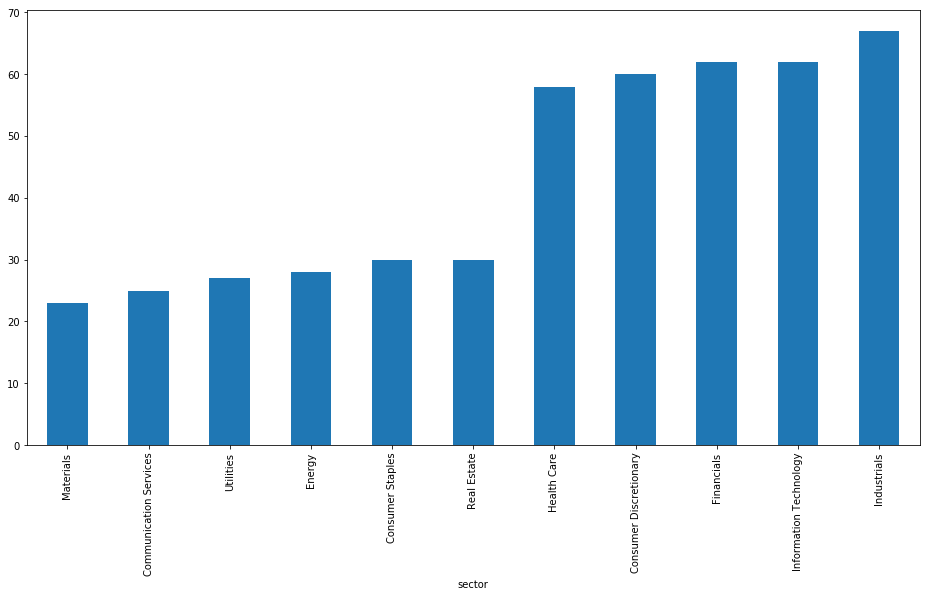

In [80]:
plt.figure(figsize=(16,8))
def nunik(s):
    return s.nunique()
allStocks.groupby('sector')['name'].agg(nunik).sort_values().plot(kind='bar')

# Visualizing some Data

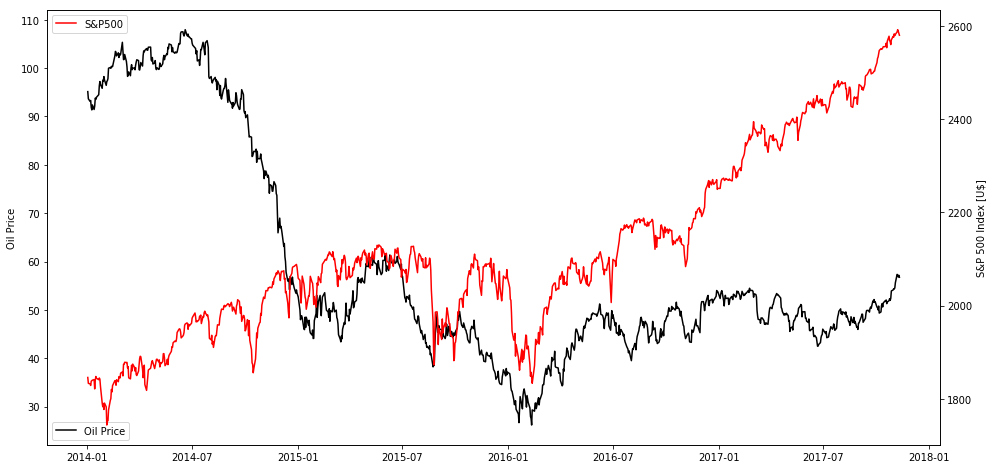

In [73]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,1,1)
f=plt.plot(oil_price.Price, 'k', label="Oil Price")
plt.legend(loc=3)
plt.ylabel("Oil Price")

ax2 = ax1.twinx()
plt.plot(sp500["Open"], 'r', label="S&P500")
plt.ylabel("S&P 500 Index [U$]")
plt.legend(loc="best")
plt.plot()
figsize=(16, 8)



### based on the above indices we can subdived different interval to look into more corrolated stock behaviours

Text(2017-02-01, 2400, 'OilConst-SpUp')

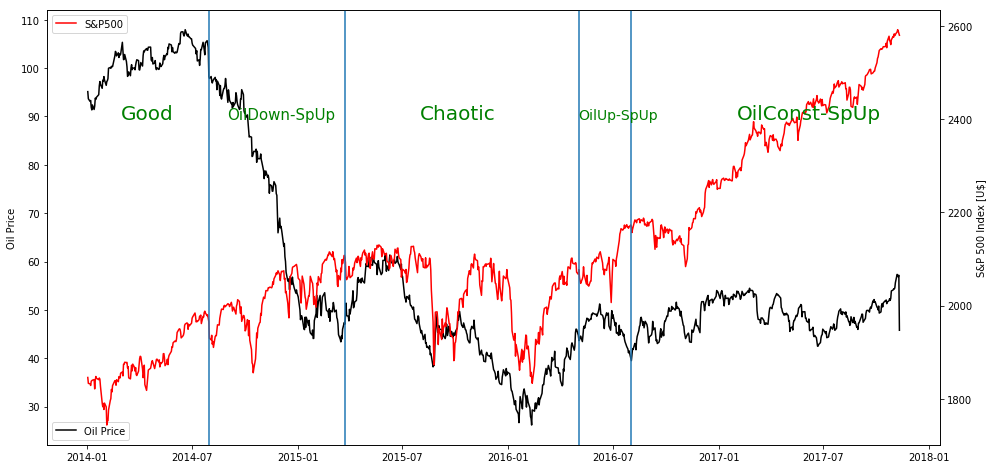

In [114]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,1,1)
f=plt.plot(oil_price.Price, 'k', label="Oil Price")
plt.legend(loc=3)
plt.ylabel("Oil Price")

ax2 = ax1.twinx()
plt.plot(sp500["Open"], 'r', label="S&P500")
plt.ylabel("S&P 500 Index [U$]")
plt.legend(loc="best")
plt.plot()
figsize=(16, 8)

plt.text('2014-03-01',2400, "Good", family="sans-serif",size=20,color='g')
plt.axvline(x='2014-08-01')
plt.text('2014-09-01',2400, "OilDown-SpUp", family="sans-serif",size=15,color='g')
plt.axvline(x='2015-03-24')
plt.text('2015-08-01',2400, "Chaotic", family="sans-serif",size=20,color='g')
plt.axvline(x='2016-05-03')
plt.text('2016-05-01',2400, "OilUp-SpUp", family="sans-serif",size=14,color='g')
plt.axvline(x='2016-08-01')
plt.text('2017-02-01',2400, "OilConst-SpUp", family="sans-serif",size=20,color='g')



### lets add these intervals to the data

In [83]:
allStocks['phase']=""
allStocks.loc[:'2014-08-01','phase']='good'
allStocks.loc['2014-08-01':'2015-03-24','phase']='oilDown-spUp'
allStocks.loc['2015-03-24':'2016-04-03','phase']='chaotic'
allStocks.loc['2016-04-03':'2016-08-01','phase']='oilUp-spUp'
allStocks.loc['2016-08-01':,'phase']='oilConst-spUp'
allStocks['phase'].unique()

array(['good', 'oilDown-spUp', 'chaotic', 'oilUp-spUp', 'oilConst-spUp'], dtype=object)

# Part2 -investigating the data
In order to be able to measure a stock performance we define two variables. First that is called **return** represets rate of changes of price per day and the **absolute return** which simply is normalization of the prices based on the first day price:


In [84]:
allStocks['returns']=(allStocks['Open']/allStocks['Open'].shift(1))-1

allStocks['absolute return']=0
for company in allStocks.company.unique():
    sliceofdata=allStocks[allStocks.company==company]
    allStocks.loc[allStocks.company==company,'absolute return']=sliceofdata.Open/sliceofdata.Open[0]

### Q1. Which defined phases in above plot, has more volatality?
basically we are trying to figure out which phase is associated with more variations in stock price.

Text(0.5, 1.0, 'Standard deviation of returns')

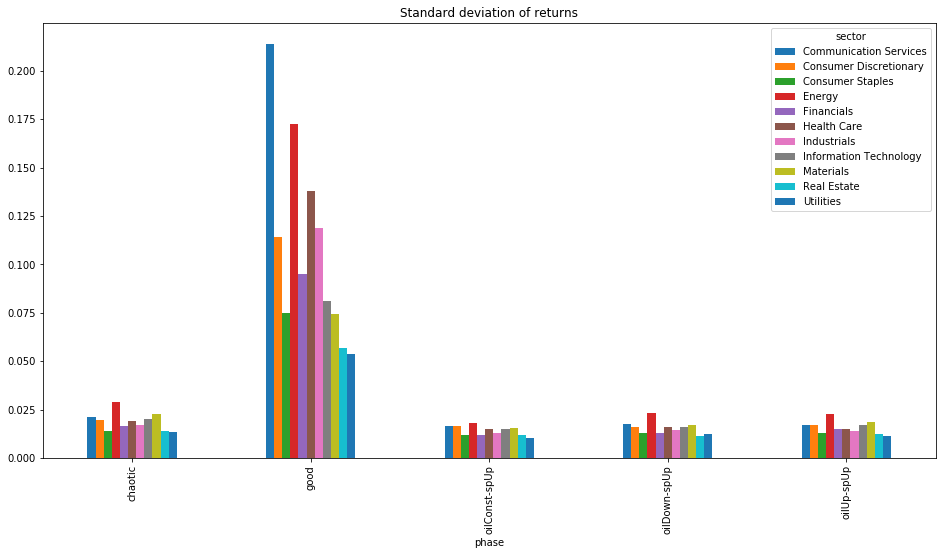

In [92]:
pv2=pd.pivot_table(allStocks,'returns','phase','sector',aggfunc='std')
pv2.plot(kind='bar',figsize=(16,8))
plt.title('Standard deviation of returns')

surprisingly the volatality is higher in the good market. this can be due to the higher risk acceptance in the healthy market 

## Q2. what are the companies with high medians in their returns?
For defining best companies we have to have a measure. Here we will investigate the median of the returns of the compies and will select the top most medians

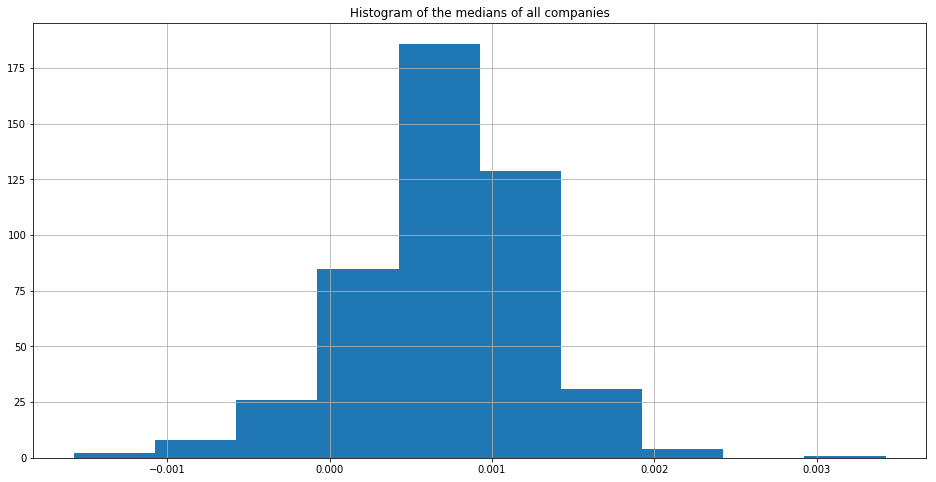

In [118]:
allStocks.groupby('company')['returns'].agg('median').hist(figsize=(16,8))
plt.title('Histogram of medians of all companies');

Text(0.5, 1.0, 'Companies with high medians in their returns')

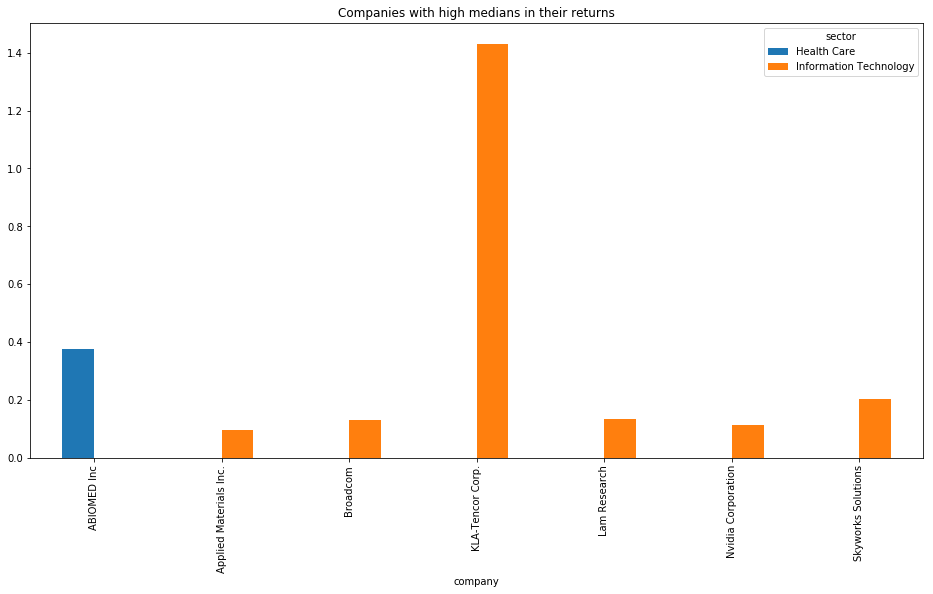

In [125]:
med=allStocks.groupby('company')['returns'].agg('median').median()# median of the above histogram
mean=allStocks.groupby('company')['returns'].agg('median').mean()# mean of the above histogram
std=allStocks.groupby('company')['returns'].agg('median').std()# std of the above histogram

pass_companies2=dict(allStocks.groupby('company')['returns'].agg('median')>mean+2*std)#companies with medians more than mean+2std
#the above will return a dictionary containing name of the company as key and True or False as value. with this dictionary, 
#we can extract the companies using the bellow line
passStocks2=allStocks[allStocks['company'].map(pass_companies2)]

#now that we have a small list of companies we plot the maximum return for each of these companies
pv2=pd.pivot_table(passStocks2,'returns',index='company',columns='sector',aggfunc='max')
pv2.plot(kind='bar',figsize=(16,8));
plt.title('Companies with high medians in their returns')

## Q3. what are the highest median for the returns in each sector?

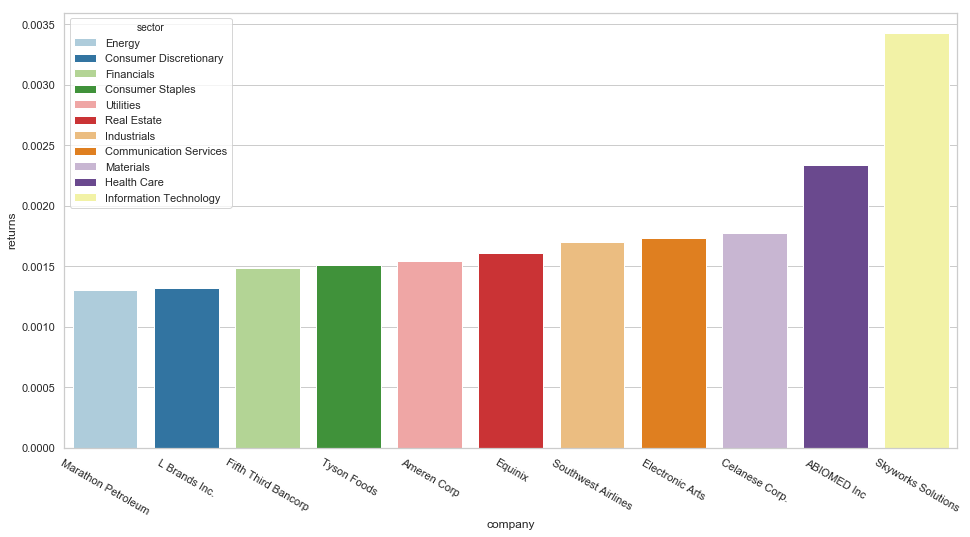

In [138]:
def get_max_returns(group, key, n=1):
    totals = group.groupby(key)['returns'].median();
    return totals.sort_values(ascending=False)[:n];

grouped=allStocks.groupby('sector');
tb=grouped.apply(get_max_returns,'company');
tb=tb.reset_index().sort_values(by='returns');
sn.set(style="whitegrid");
fig, ax = plt.subplots(figsize=(16,8))
sn.barplot(ax=ax,x='company',y='returns',hue='sector',data=tb, dodge=False,palette="Paired");
plt.setp(ax.get_xticklabels(), rotation=-30);


## Q4. Comparing all the stocks which of them are better, in terms of absolute return?

In [140]:
table2=pd.pivot_table(allStocks,values=['absolute return'],index=allStocks.index,columns='company')
table2.head()
table2['max absolute return']=table2.idxmax(axis=1)
table2['max absolute return'].value_counts().sort_values(ascending=False)[:4]

(absolute return, ABIOMED Inc)                290
(absolute return, Skyworks Solutions)         278
(absolute return, Nvidia Corporation)         264
(absolute return, American Airlines Group)     73
Name: max absolute return, dtype: int64

in these result non of the famous brands and stocks are available. Se lets plot them altogether to make sure, the analysis are making sense:

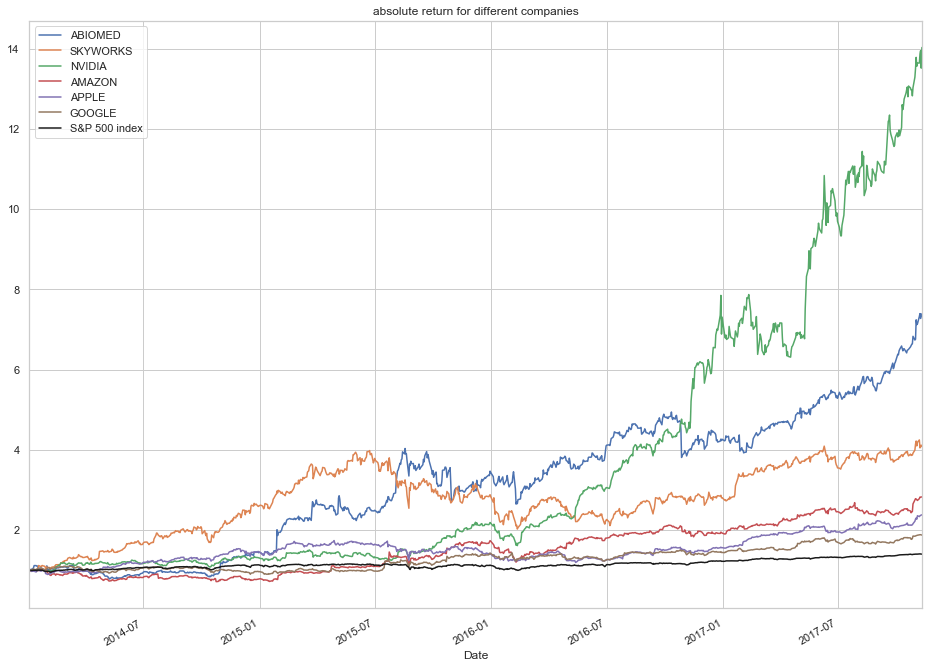

In [144]:
ABIOMED=allStocks[allStocks['company']=='ABIOMED Inc']
SKYWORKS=allStocks[allStocks['company']=='Skyworks Solutions']
NVIDIA=allStocks[allStocks['company']=='Nvidia Corporation']

apple = [s for s in allStocks.company.unique() if "apple" in s.lower()][0]
amazon = [s for s in allStocks.company.unique() if "amazon" in s.lower()][0]
google = [s for s in allStocks.company.unique() if "alphabet" in s.lower()][0]
APPLE=allStocks[allStocks['company']==apple]
AMAZON=allStocks[allStocks['company']==amazon]
GOOGLE=allStocks[allStocks['company']==google]

sp500['absolute return']=sp500.Open/sp500.Open[0]



ABIOMED['absolute return'].plot(label='ABIOMED', figsize=(16, 12), title='absolute return for different companies')
SKYWORKS['absolute return'].plot(label='SKYWORKS')
NVIDIA['absolute return'].plot(label='NVIDIA')
AMAZON['absolute return'].plot(label='AMAZON')
APPLE['absolute return'].plot(label='APPLE')
GOOGLE['absolute return'].plot(label='GOOGLE')
sp500['absolute return'].plot(label='S&P 500 index',color='k')
plt.legend()